In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler

In [3]:
# data
rnd = 42

In [4]:
df = pd.read_csv('train.csv')

In [5]:
df.set_index('Id', inplace=True)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['SalePrice']), df['SalePrice'], test_size=0.2, random_state=rnd)

In [7]:
# get cat features
cat_feat = df.dtypes[df.dtypes == object].index
# fill cat feat with nans
df[cat_feat] = df[cat_feat].fillna('nan')
# get num features without target value
num_feat = [f for f in df if f not in cat_feat and f not in ['SalePrice']]

In [8]:
# scaling
scaler = StandardScaler()
df[num_feat] = scaler.fit_transform(df[num_feat])

In [9]:
# dummies
train_dummies = pd.get_dummies(X_train[cat_feat], columns=cat_feat)
test_dummies = pd.get_dummies(X_test[cat_feat], columns=cat_feat)

dummy_cols = list(set(train_dummies) & set(test_dummies))

dummy_train = train_dummies[dummy_cols]
dummy_test = test_dummies[dummy_cols]

X_train = pd.concat([X_train[num_feat].fillna(-999),
                     dummy_train], axis=1)

X_test = pd.concat([X_test[num_feat].fillna(-999),
                     dummy_test], axis=1)

## Random Forest

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


In [11]:
rf = RandomForestRegressor(n_estimators=20, max_depth=5)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=20, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [12]:
# predictions
train_pred = rf.predict(X_train)
test_pred = rf.predict(X_test)

In [13]:
from sklearn.metrics import accuracy_score

In [14]:
print('Train Score: {:.3f} \nTest Score: {:.3f}'.format(rf.score(X_train, y_train),
                                                                         rf.score(X_test, y_test)))

Train Score: 0.898 
Test Score: 0.853


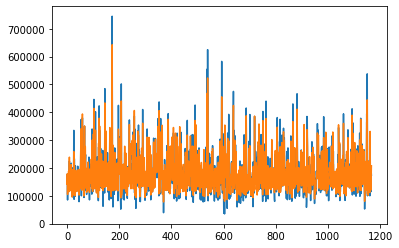

In [15]:
plt.plot(y_train.to_list())
plt.plot(train_pred)

Most important features:
OverallQual	0.612
GrLivArea	0.137
TotalBsmtSF	0.044
2ndFlrSF	0.029
1stFlrSF	0.023
BsmtFinSF1	0.020
GarageCars	0.017
GarageArea	0.016
PoolArea	0.009
BsmtQual_Ex	0.008
YearBuilt	0.008
TotRmsAbvGrd	0.007
KitchenQual_Gd	0.007


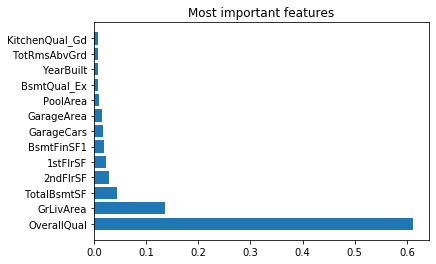

In [16]:
importances = rf.feature_importances_
feature_names = X_train.columns

most_important = {feature_names[i]: imp for i, imp in enumerate(importances) if imp > 0.005}
most_important = {k: v for k, v in sorted(most_important.items(), key=lambda item: -item[1])}
print("Most important features:") 
print('\n'.join('{}\t{:.3f}'.format(k,v) for k, v in most_important.items()))

fig, ax = plt.subplots()
y_pos = np.arange(len(most_important))
ax.barh(y_pos, most_important.values())
ax.set_yticks(y_pos)
ax.set_yticklabels(most_important.keys())
ax.set_title('Most important features')
plt.show()

## Stacking

In [17]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.tree import DecisionTreeRegressor

In [18]:
estimators = [
    ('linear', LinearRegression()),
    ('sgd', SGDRegressor()),
    ('tree', RandomForestRegressor())
]

In [19]:
# cv=10 enables 10-fold cross-validation
reg = StackingRegressor(estimators, final_estimator=RandomForestRegressor(n_estimators=20, max_depth=5), cv=10)

In [20]:
reg.fit(X_train, y_train)

StackingRegressor(cv=10,
                  estimators=[('linear',
                               LinearRegression(copy_X=True, fit_intercept=True,
                                                n_jobs=None, normalize=False)),
                              ('sgd',
                               SGDRegressor(alpha=0.0001, average=False,
                                            early_stopping=False, epsilon=0.1,
                                            eta0=0.01, fit_intercept=True,
                                            l1_ratio=0.15,
                                            learning_rate='invscaling',
                                            loss='squared_loss', max_iter=1000,
                                            n_iter_no_change=5, penalty='l2',
                                            power_t=0....
                  final_estimator=RandomForestRegressor(bootstrap=True,
                                                        ccp_alpha=0.0,
                  

In [21]:
train_pred = reg.predict(X_train)
test_pred = reg.predict(X_test)

In [22]:
print('Train Score: {:.3f} \nTest Score: {:.3f}'.format(reg.score(X_train, y_train),
                                                                         reg.score(X_test, y_test)))

Train Score: 0.937 
Test Score: 0.862


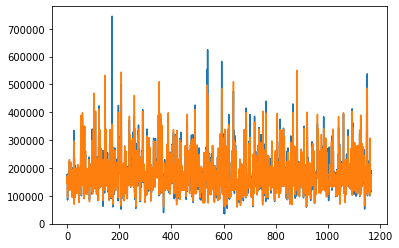

In [23]:
plt.plot(y_train.to_list())
plt.plot(train_pred)

## Results
RandomForest score 0.853

StackingRegressor score 0.862